In [37]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [38]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [39]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [40]:
# create engine to hawaii.sqlite
database = ("Resources/hawaii.sqlite")
engine = create_engine(f"sqlite:///{database}")

In [41]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [42]:
# View all of the classes that automap found
inspect(engine).get_table_names()

['measurement', 'station']

In [70]:
Base.classes.keys()

['measurement', 'station']

In [43]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [44]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [45]:
# Find the most recent date in the data set.
for column in inspect(engine).get_columns('measurement'):
    print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [46]:
for column in inspect(engine).get_columns('station'):
    print(column["name"],column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [47]:
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Sort the dataframe by date

# Use Pandas Plotting with Matplotlib to plot the data

In [87]:
# FInding the last date
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

In [88]:
last_date = dt.datetime.strptime(last_date, "%Y-%m-%d")

In [89]:
last_date = last_date.date()
print(last_date)

2017-08-23


In [90]:
start_date = last_date - dt.timedelta(days=365)
print(start_date)

2016-08-23


In [93]:
# Perform a query to retrieve the data and precipitation scores
data = session.query(*selection).filter(Measurement.date <= last_date).filter(Measurement.date >= start_date).all()

In [97]:
# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(data, columns=['date','prcp']).set_index('date')
df.head()

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


In [103]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.agg(["count","mean","median","min","max","std","sem"])

,prcp
count,2021.000000
mean,0.177279
median,0.020000
min,0.000000
max,6.700000
std,0.461190
sem,0.010259


In [101]:
#sort index 
df = df.sort_index()

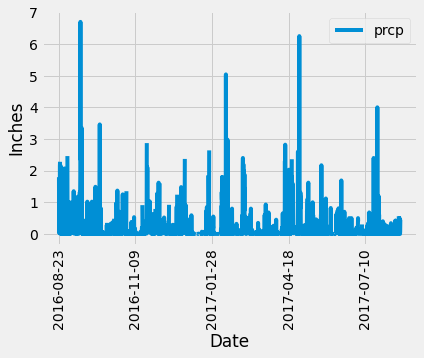

In [111]:
#plot a line chart for the data
chart = df.plot(kind="line", legend=True)
chart.set_xlabel("Date")
chart.set_ylabel("Inches")
plt.xticks(rotation="vertical")
plt.show()

# Exploratory Station Analysis

In [ ]:
# Design a query to calculate the total number stations in the dataset


In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()